# Part 1 - estimation

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

In [7]:
df = pd.read_csv("CVD_cleaned.csv")
print("average weight of smokers and non-smokers:")
print(df.groupby('Smoking_History')['Weight_(kg)'].mean())

average weight of smokers and non-smokers:
Smoking_History
No     82.665153
Yes    84.695707
Name: Weight_(kg), dtype: float64


In [34]:
def calc_CI(avg_non_smokers_,avg_smokers_,se_non_smokers_,se_smokers_):
    # calculating the confidence intervals
    CI_non_smokers = [avg_non_smokers_ - 2*se_non_smokers_, avg_non_smokers_+2*se_non_smokers_]
    CI_smokers = [avg_smokers_-2*se_smokers_, avg_smokers_+2*se_smokers_]
    return {'CI_smokers': CI_smokers, 'CI_non_smokers':CI_non_smokers}

In [94]:
def part_1():
    #filtering
    smokers_df = df[df["Smoking_History"] == 'Yes']['Weight_(kg)']
    non_smokers_df = df[df["Smoking_History"] == 'No']['Weight_(kg)']
    # getting n
    n_non_smokers = len(non_smokers_df)
    n_smokers = len(smokers_df)
    # using biased estimator for the variance
    non_smokers_sample_variance =non_smokers_df.var(ddof=0)
    smokers_sample_variance =smokers_df.var(ddof=0)
    se_non_smokers = ((1/n_non_smokers)*non_smokers_sample_variance)**0.5
    se_smokers = ((1/n_smokers)*smokers_sample_variance)**0.5
    # getting the average per group
    avg_non_smokers = non_smokers_df.mean()
    avg_smokers = smokers_df.mean()
    interval = calc_CI(avg_non_smokers,avg_smokers,se_non_smokers,se_smokers)
    print(f"confidence intervals for smokers:{interval['CI_smokers']}")
    print(f"confidence intervals for non smokers:{interval['CI_non_smokers']}\n")

In [95]:
part_1()

confidence intervals for smokers:[84.5725186413171, 84.81889517427099]
confidence intervals for non smokers:[82.56503785201866, 82.76526821027593]



we know that the MLE of the mean is the sample mean which is asymptotically normal, hence the assumption is valid.
the confidence intervals we got are not overlapping, meaning we can say with 95 percent certainty that there is a
difference between the mean weight of smokers and non-smokers.

# part 3 - Different Sample Sizes

## part 3 - a,b,c

In [92]:
def parts_abc(smokers_mean, non_smokers_mean, part_d=False):
    """
    Perform statistical analysis for parts A, B, and C, and optionally D.

    Parameters:
    smokers_mean (float): Expected mean weight for smokers.
    non_smokers_mean (float): Expected mean weight for non-smokers.
    part_d (bool, optional): If True, include Part D analysis. Default is False.

    Returns:
    None

    This function performs statistical analysis for parts A, B, and C of the problem,
    and optionally for Part D if specified. It calculates confidence intervals,
    performs Wald hypothesis tests, and analyzes the percentage of intervals
    containing the expected means.

    Parameters:
    - smokers_mean: Expected mean weight for smokers.
    - non_smokers_mean: Expected mean weight for non-smokers.
    - part_d: Boolean indicating whether to include Part D analysis (optional).

    For each sample size in 'sizes':
    - Generate intervals and p-values for smokers and non-smokers.
    - Calculate the percentage of intervals containing the expected means.

    If 'part_d' is True:
    - Plot the intervals' widths and p-values.
    - Print the percentage of intervals containing the expected means for both groups.

    Example usage:
    parts_abc(70, 65, part_d=True)
    """

    np.random.seed(42)
    sizes = [30, 50, 100, 500]
    intervals = {size: {'smokers': [], 'non_smokers': []} for size in sizes}
    p_vals = {size: [] for size in sizes}
    within_interval = {'smokers': 0, 'non_smokers': 0}
    rounds = 100 if part_d else 1

    for size in sizes:
        for _ in range(rounds):
            sample = df.sample(n=size)
            # Filtering
            smokers_df = sample[sample["Smoking_History"] == 'Yes']['Weight_(kg)']
            non_smokers_df = sample[sample["Smoking_History"] == 'No']['Weight_(kg)']

            # Getting sample sizes
            n_non_smokers = len(non_smokers_df)
            n_smokers = len(smokers_df)

            # Using biased estimator for the variance
            non_smokers_sample_variance = non_smokers_df.var(ddof=0)
            smokers_sample_variance = smokers_df.var(ddof=0)
            se_non_smokers = ((1/n_non_smokers) * non_smokers_sample_variance)**0.5
            se_smokers = ((1/n_smokers) * smokers_sample_variance)**0.5

            # Getting the average per group
            avg_non_smokers = non_smokers_df.mean()
            avg_smokers = smokers_df.mean()

            # Calculate confidence intervals
            interval = calc_CI(avg_non_smokers, avg_smokers, se_non_smokers, se_smokers)
            print(f"Intervals for sample size: {size}")
            print(f"Confidence intervals for smokers: {interval['CI_smokers']}")
            print(f"Confidence intervals for non-smokers: {interval['CI_non_smokers']}\n")

            # Calculate Wald standard error and p-value
            wald_se_hat = (smokers_sample_variance/n_smokers + non_smokers_sample_variance/n_non_smokers)**0.5
            P_val = wald_test(avg_smokers - avg_non_smokers, 0, wald_se_hat)

            # Update intervals and p-values (Part D)
            if part_d:
                intervals[size]['smokers'].append(interval['CI_smokers'][1] - interval['CI_smokers'][0])
                intervals[size]['non_smokers'].append(interval['CI_non_smokers'][1] - interval['CI_non_smokers'][0])
                p_vals[size].append(P_val)

            # Check if expected means are within intervals
            if number_in_interval(smokers_mean, interval['CI_smokers']):
                within_interval['smokers'] += 1
            if number_in_interval(non_smokers_mean, interval['CI_non_smokers']):
                within_interval['non_smokers'] += 1

    # Perform Part D analysis if specified
    if part_d:
        plot_intervals(intervals, sizes)
        plot_P_val(p_vals, sizes)
        print(f"Percentage of intervals that the smokers average was within the interval: {within_interval['smokers'] * 0.25}%")
        print(f"Percentage of intervals that the non-smokers average was within the interval: {within_interval['non_smokers'] * 0.25}%")

In [70]:
def wald_test(theta_hat,theta_0,se_hat,verbose = True):
    """
    Perform a Wald hypothesis test.

    Parameters:
    theta_hat (float): Estimated parameter value.
    theta_0 (float): Null hypothesis value to be tested.
    se_hat (float): Standard error estimate of the parameter.
    verbose (bool, optional): If True, print test details. Default is True.

    Returns:
    float: Two-sided p-value for the Wald test.
    """
    T = theta_hat - theta_0 / se_hat
    W_test_quantile = stats.norm.ppf(0.975)
    P_val = 2*stats.norm.cdf(-abs(T))
    if verbose:
        print("Wald Test with alpha = 0.05")
        print(f"H0: theta = {theta_0}")
        print(f"H1: theta != {theta_0}")
        print(f"Test statistic: {T:.5f}")
        print(f"{abs(T)} > ? {W_test_quantile}")
        print(f"Rejected: {abs(T)>W_test_quantile}")
        print(f"P value: {P_val:.5f}\n\n")
    return P_val

In [90]:
def plot_intervals(intervals,sizes):
    """
    Plot histograms of interval widths for smokers and non-smokers.

    Parameters:
    intervals (dict): A dictionary containing interval widths for each sample size.
                      Expected structure: {size: {'smokers': [...], 'non_smokers': [...]}, ...}
    sizes (list): List of sample sizes.

    Returns:
    None

    This function creates a grid of histograms to visualize the distribution of interval
    widths for smokers and non-smokers at different sample sizes.

    Parameters:
    - intervals: A dictionary containing interval widths for each sample size.
    - sizes: List of sample sizes.

    The function generates histograms for both smokers and non-smokers, displaying the
    distribution of interval widths for each sample size. Each histogram represents a
    different sample size and is displayed side by side.

    Example usage:
    plot_intervals(intervals, [30, 50, 100, 500])
    """
    # Create subplots for each size with two histograms side by side
    fig, axes = plt.subplots(len(sizes), 2, figsize=(12, 8))

    # Loop through sizes and create subplots
    for i, size in enumerate(sizes):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        # Plot histogram for smokers
        ax1.hist(intervals[size]['smokers'], bins=20, alpha=0.5, color='royalblue', label='Smokers')
        ax1.set_title(f'Size: {size}')
        ax1.set_xlabel('Value')
        ax1.set_ylabel('Frequency')
        ax1.legend()

        # Plot histogram for non-smokers
        ax2.hist(intervals[size]['non_smokers'], bins=20, alpha=0.5, color='orange', label='Non-Smokers')
        ax2.set_title(f'Size: {size}')
        ax2.set_xlabel('Interval Size')
        ax2.set_ylabel('Frequency')
        ax2.legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


In [66]:
def number_in_interval(number, interval):
    """
    Check if a number falls within a specified interval.

    Parameters:
    number (float): The number to be checked.
    interval (tuple): A tuple containing the lower and upper bounds of the interval.

    Returns:
    bool: True if the number is within the interval, False otherwise.
    """
    interval_start, interval_end = interval
    return interval_start <= number <= interval_end

In [60]:
def plot_P_val(p_vals,sizes):
    """
    Plot histograms of p-values distribution for different sample sizes.

    Parameters:
    p_vals (dict): A dictionary containing p-values for each sample size.
                   Expected structure: {size: [...], ...}
    sizes (list): List of sample sizes.

    Returns:
    None

    This function creates a grid of histograms to visualize the distribution of p-values
    for different sample sizes.

    Parameters:
    - p_vals: A dictionary containing p-values for each sample size.
    - sizes: List of sample sizes.

    The function generates histograms representing the distribution of p-values for each
    sample size. Each histogram represents a different sample size and is displayed side by side.

    Example usage:
    plot_P_val(p_vals, [30, 50, 100, 500])
    """
    # Calculate grid dimensions
    num_rows = 2
    num_cols = 2

    # Create a grid of plots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    # Flatten the axes array to iterate over all subplots
    axes = axes.flatten()

    # Loop through sizes and create plots
    for i, size in enumerate(sizes):
        ax = axes[i]
        ax.hist(p_vals[size], bins=20, alpha=0.7, color='green')
        ax.set_title(f'P-Values Distribution (Size: {size})')
        ax.set_xlabel('P-Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


In [93]:
non_smokers_avg = df[df["Smoking_History"] == 'No']['Weight_(kg)'].mean()
smokers_avg = df[df["Smoking_History"] == 'Yes']['Weight_(kg)'].mean()
parts_abc(smokers_avg,non_smokers_avg)

Intervals for sample size: 30
Confidence intervals for smokers: [68.60700100976203, 90.42992206716104]
Confidence intervals for non-smokers: [68.29149438750295, 91.10615267132059]

Wald Test with alpha = 0.05
H0: theta = 0
H1: theta != 0
Test statistic: -0.18036
0.18036199095023164 > ? 1.959963984540054
Rejected: False
P value: 0.85687


Intervals for sample size: 50
Confidence intervals for smokers: [78.8947751754022, 91.57522482459783]
Confidence intervals for non-smokers: [73.8658326552762, 90.72131020186666]

Wald Test with alpha = 0.05
H0: theta = 0
H1: theta != 0
Test statistic: 2.94143
2.941428571428588 > ? 1.959963984540054
Rejected: True
P value: 0.00327


Intervals for sample size: 100
Confidence intervals for smokers: [75.24090799579916, 88.28259200420085]
Confidence intervals for non-smokers: [76.22315686816673, 87.43217646516653]

Wald Test with alpha = 0.05
H0: theta = 0
H1: theta != 0
Test statistic: -0.06592
0.06591666666662377 > ? 1.959963984540054
Rejected: False
P va

we can notice that the confidence intervals are much larger with smaller sample sizes, but we seem to begin
converging as the sample sizes increase

## part 3 - d

intervals for sample size: 30
confidence intervals for smokers:[68.60700100976203, 90.42992206716104]
confidence intervals for non smokers:[68.29149438750295, 91.10615267132059]

Wald Test with alpha = 0.05
H0: theta = 0
H1: theta != 0
Test statistic: -0.18036
0.18036199095023164 > ? 1.959963984540054
Rejected: False
P value: 0.85687


intervals for sample size: 30
confidence intervals for smokers:[79.13418885428707, 89.66314447904627]
confidence intervals for non smokers:[73.64346651919341, 92.60986681413995]

Wald Test with alpha = 0.05
H0: theta = 0
H1: theta != 0
Test statistic: 1.27200
1.2719999999999914 > ? 1.959963984540054
Rejected: False
P value: 0.20337


intervals for sample size: 30
confidence intervals for smokers:[68.36859478019764, 96.92140521980235]
confidence intervals for non smokers:[69.2315330511698, 91.02346694883019]

Wald Test with alpha = 0.05
H0: theta = 0
H1: theta != 0
Test statistic: 2.51750
2.5174999999999983 > ? 1.959963984540054
Rejected: True
P value: 0.

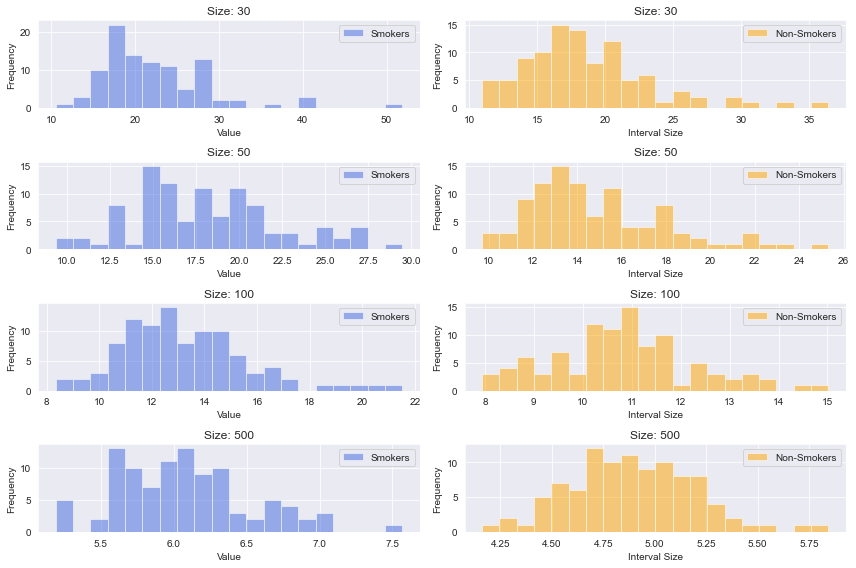

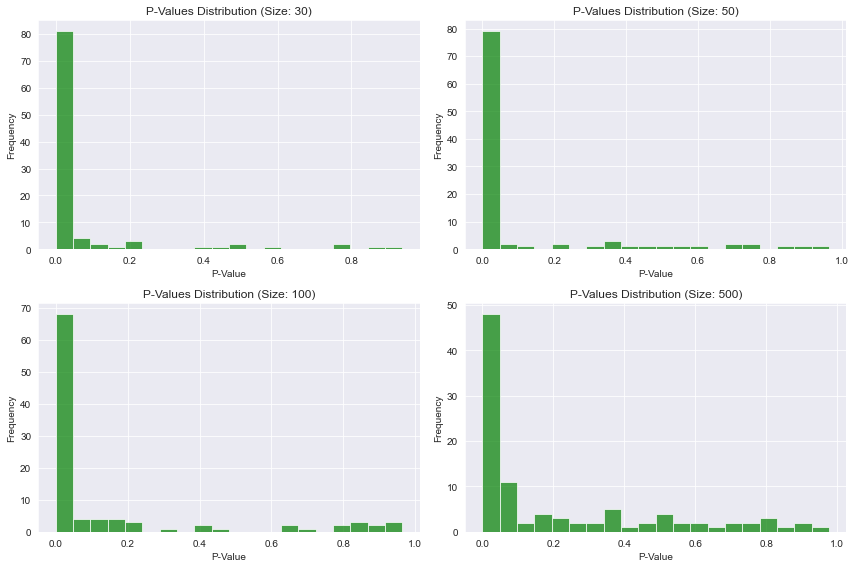

percentage of intervals that the smokers average was within the interval:90.5%
percentage of intervals that the non smokers average was within the interval:94.5%


In [91]:
parts_abc(smokers_avg,non_smokers_avg,part_d=True)

### Conclusions

we can notice that the confidence intervals are much larger with smaller sample sizes, and in most cases, we can
reject the null hypothesis with at least 95% certainty